In [123]:
# importing libraries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import cufflinks as cf
import seaborn as sns
import pandas as pd
import numpy as np
import quandl
import plotly
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import Markdown, display
from matplotlib.ticker import FuncFormatter
from pandas.core.base import PandasObject
from datetime import datetime

# Setting pandas dataframe display options
pd.set_option("display.max_rows", 20)
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)

pd.options.display.float_format = '{:,.4f}'.format

# Set plotly offline
init_notebook_mode(connected=True)

# Set matplotlib style
plt.style.use('seaborn')

# Set cufflinks offline
cf.go_offline()

# Defining today's Date
from datetime import date
today = date.today()

import PortfolioLab as pl

In [587]:
ISINs = ['IWDA', 'IE00B18GC888', 'XAD5']
Nomes=['IWDA', 'VG_GB', 'XAD5']

Quotes = pd.read_csv('D:/GDrive/_GitHub/Backtester/Data/Cotacoes_diarias_all.csv', index_col='Date', parse_dates=True)[ISINs].dropna().loc[:'2020-12-31']
Quotes.columns=Nomes

In [589]:
%%time
portfolio_pl = pl.compute_portfolio(Quotes, [0.34, 0.33, 0.33])

Wall time: 85.8 ms


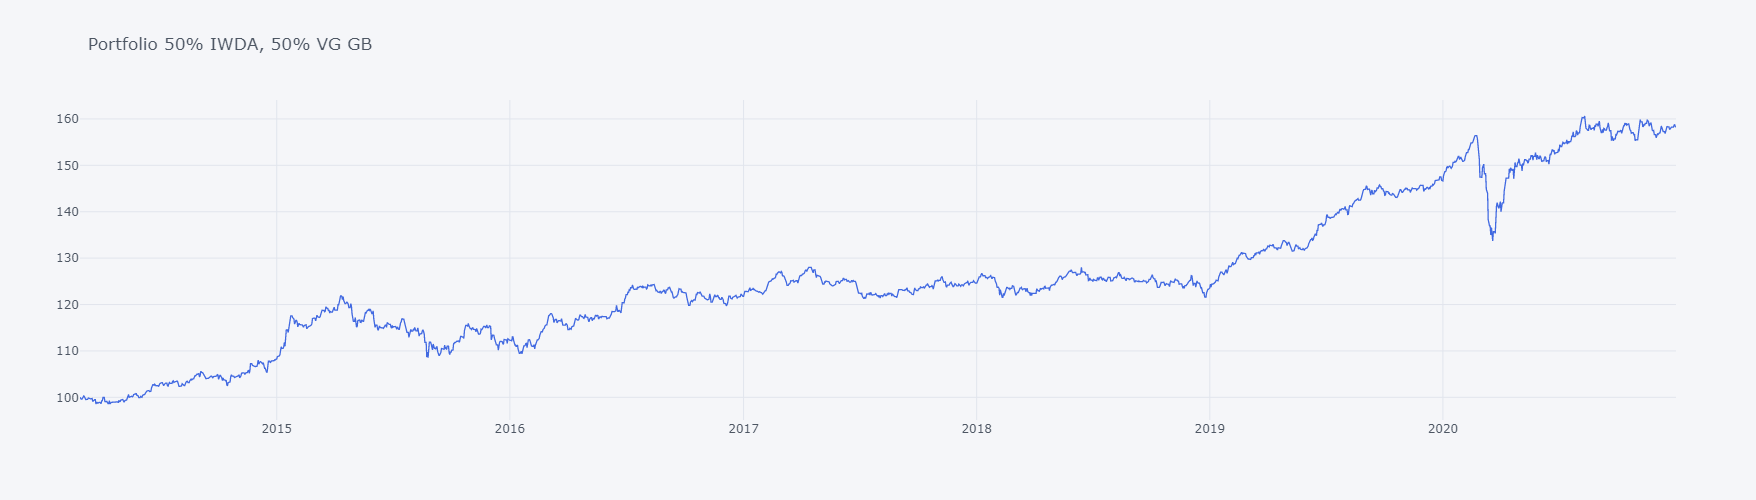

In [591]:
portfolio_pl.iplot(dimensions=pl.dimensions, color='royalblue', title='Portfolio 50% IWDA, 50% VG GB')

In [127]:
portfolio_pl

,Portfolio
2014-02-27,100.0000
2014-02-28,100.0500
2014-03-01,100.0500
2014-03-02,100.0500
2014-03-03,99.3900
...,...
2016-12-27,126.8200
2016-12-28,127.1600
2016-12-29,126.4800
2016-12-30,126.2000


In [128]:
pl.compute_performance_table(portfolio_pl)

**Performance from 2014-02-27 to 2016-12-31 (≈ 2.8 years)**

,CAGR,Return,StdDev,Sharpe,Max DD,MAR
Portfolio,8.52%,26.20%,7.03%,1.2100,-11.57%,0.7400


## Criação de nova função de portfolio com contribuição de cada activo

In [129]:
%%time
#it

weights = [0.5, 0.5]
n_assets = len(weights)

# Normalizar valores para 1
Quotes_norm = Quotes / Quotes.iloc[0]

# Calcular a evolução de cada activo
Evolução_individual = Quotes_norm * weights * 100

# Contribuição diária
Contribuição_diária_individual = Evolução_individual - Evolução_individual.shift(1)

# Contribuição individual cumulativa
Contribuição_cumulativa_individual = Contribuição_diária_individual.cumsum()

# Portfolio calculation as sum of cumulative contributions
Portfolio = pd.DataFrame(Contribuição_cumulativa_individual.sum(axis=1) + 100)

# Cálculo de novos pesos, tendo em consideração a evolução do portfolio
# (para os novos períodos pós rebalanceamentos)
weights = np.repeat(Portfolio.iloc[-1][0], repeats=n_assets) * weights

Wall time: 3.99 ms


In [130]:
# start = Quotes.index[0]
# end = Quotes.index[-1]

# rebalancing_days = pd.date_range(start=start, end=end, freq='A').union(start_index)

# start_index = pd.date_range(start=start, end=start, periods=1)

# contributions_all = pd.DataFrame()

# for i in range(1, len(rebalancing_days)):
#     quotes = Quotes[rebalancing_days[i-1]:rebalancing_days[i]]
#     quotes_ret = quotes.pct_change().dropna()
#     quotes_norm = quotes / quotes.iloc[0]
#     rolling_contribution_this_year = (quotes_norm * weights)    

#     rolling_weights = rolling_contribution.div(rolling_contribution.sum(axis=1), axis=0)

In [131]:
%%time

Contribuição_diária_individual_all = pd.DataFrame()

# Start and End date for backtest
start = Quotes.index[0]
end = Quotes.index[-1]

# Calculate the rebalancing days dates (including inception date)
start_index = pd.date_range(start=start, end=start, periods=1)
rebalancing_days = pd.date_range(start=start, end=end, freq='A').union(start_index)

# Number of assets and given weights
weights = [0.5, 0.5]
n_assets = len(weights)

# Start Value
start_value = 100

for i in range(1, len(rebalancing_days)):
    # Select period between rebalances
    quotes = Quotes[rebalancing_days[i-1]:rebalancing_days[i]]
    # Normalizing quotes to 1
    quotes_norm = quotes / quotes.iloc[0]
    # Compute daily individual evolution
    Evolução_individual = quotes_norm * weights * 100
    # Compute daily individual contribution
    Contribuição_diária_individual = Evolução_individual - Evolução_individual.shift(1)    
    Contribuição_diária_individual_all = pd.concat([Contribuição_diária_individual_all, Contribuição_diária_individual])    
    # Contribuição individual cumulativa
    Contribuição_cumulativa_individual = Contribuição_diária_individual.dropna().cumsum()
    # Portfolio calculation as sum of cumulative contributions
    Portfolio_period = Contribuição_cumulativa_individual.sum(axis=1) + 100
    print(Contribuição_diária_individual)
    # Cálculo de novos pesos, tendo em consideração a evolução do portfolio
    # (para os novos períodos pós rebalanceamentos)
    weights = (np.repeat(Portfolio_period.iloc[-1], repeats=n_assets) * weights) / 100   
    
    Portfolio = pd.DataFrame(Contribuição_diária_individual_all.dropna().cumsum().sum(axis=1) + 100)

              IWDA   VG_GB
Date                      
2014-02-27     nan     nan
2014-02-28  0.0866 -0.0375
2014-03-01  0.0000  0.0000
2014-03-02  0.0000  0.0000
2014-03-03 -0.7622  0.1018
...            ...     ...
2014-12-27  0.0000  0.0000
2014-12-28  0.0000  0.0000
2014-12-29  0.1299  0.1071
2014-12-30 -0.3638  0.0536
2014-12-31  0.2252  0.0375

[308 rows x 2 columns]
              IWDA   VG_GB
Date                      
2014-12-31     nan     nan
2015-01-01  0.0000  0.0000
2015-01-02 -0.1878  0.1254
2015-01-03  0.0000  0.0000
2015-01-04  0.0000  0.0000
...            ...     ...
2015-12-27  0.0000  0.0000
2015-12-28 -0.6451  0.0285
2015-12-29  1.2575 -0.0912
2015-12-30 -0.2123 -0.0057
2015-12-31 -0.2368  0.0456

[366 rows x 2 columns]
              IWDA   VG_GB
Date                      
2015-12-31     nan     nan
2016-01-01  0.0000  0.0000
2016-01-02  0.0000  0.0000
2016-01-03  0.0000  0.0000
2016-01-04 -1.3353  0.1323
...            ...     ...
2016-12-27  0.0864 -0.0060
2016-12

In [145]:
Contribuição_diária_individual

,IWDA,VG_GB
Date,,
2015-12-31,nan,nan
2016-01-01,0.000000,0.000000
2016-01-02,0.000000,0.000000
2016-01-03,0.000000,0.000000
2016-01-04,-1.335332,0.132333
...,...,...
2016-12-27,0.086404,-0.006015
2016-12-28,0.259212,0.084212
2016-12-29,-0.777635,0.090227


In [143]:
Portfolio.loc['2016-12-31']

0   126.248401
Name: 2016-12-31 00:00:00, dtype: float64

In [132]:
pd.options.display.float_format = '{:,.6f}'.format

valores_anuais = Portfolio.resample('A').last().pct_change()
valores_anuais

,0
Date,
2014-12-31,nan
2015-12-31,0.054525
2016-12-31,0.066626


In [133]:
valores_anuais.iloc[-1] / valores_anuais.iloc[0]

0   nan
dtype: float64

In [134]:
portfolio_pl.resample('A').last().pct_change().dropna()
# portfolio_pl

,Portfolio
2015-12-31,0.054526
2016-12-31,0.066239


In [135]:
Quotes['2018-12-31':'2019-12-31']

,IWDA,VG_GB
Date,,


In [136]:
(56.1100 / 43.3000 + 106.6400 / 101.3000) / 2

1.1742788324529387

In [137]:
(Quotes.resample('A').last().pct_change().sum(axis=1) / 2) * 100

Date
2014-12-31   0.000000
2015-12-31   5.452490
2016-12-31   6.620671
Freq: A-DEC, dtype: float64

# Nova tentativa

In [658]:
ISINs = ['IWDA', 'IE00B18GC888']
Nomes=['IWDA', 'VG_GB']

Quotes = pd.read_csv('D:/GDrive/_GitHub/Backtester/Data/Cotacoes_diarias_all.csv', index_col='Date', parse_dates=True)[ISINs].dropna().loc[:'20-12-31']
Quotes.columns=Nomes

pd.options.display.float_format = '{:,.8f}'.format

In [659]:
weights = [0.5, 0.5]
n_assets = len(weights)
n_days = len(Quotes)
start_value = 100

Evolução = Quotes / Quotes.iloc[0]

print(n_days)

UPs = np.matrix(np.repeat(weights, n_days))
UPs.shape = (n_days, 2)
UPs = pd.DataFrame(UPs)
UPs.columns = Quotes.columns
UPs.set_index(Quotes.index, inplace=True)

Evolução_no_portfolio = Evolução.mul(UPs, axis=1)

Contribuição_do_dia = Evolução_no_portfolio - Evolução_no_portfolio.shift(1)

Contribuição_no_portfolio = Contribuição_do_dia.cumsum()

Portfolio = Contribuição_no_portfolio.sum(axis=1)

Portfolio * 100 + start_value

2507


Date
2014-02-27   100.00000000
2014-02-28   100.04912079
2014-03-01   100.04912079
2014-03-02   100.04912079
2014-03-03    99.38870872
                 ...     
2021-01-03   163.07622236
2021-01-04   162.60396735
2021-01-05   162.72819196
2021-01-06   164.01311690
2021-01-07   164.01311690
Length: 2507, dtype: float64

In [328]:
UPs

matrix([[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]])

In [329]:
n_days

673

In [660]:
ISINs = ['IWDA', 'IE00B18GC888', 'XAD5']
Nomes=['IWDA', 'VG_GB', 'XAD5']

Quotes = pd.read_csv('D:/GDrive/_GitHub/Backtester/Data/Cotacoes_diarias_all.csv', index_col='Date', parse_dates=True)[ISINs].dropna().loc[:'2020']
Quotes.columns=Nomes

In [661]:
%%time

def compute_portfolio_with_contributions(df, weights, start_value=100):
    Contribuição_diária_individual_all = pd.DataFrame()

    # Start and End date for backtest
    start = df.index[0]
    end = df.index[-1]

    # Calculate the rebalancing days dates (including inception date)
    start_index = pd.date_range(start=start, end=start, periods=1)
    rebalancing_days = pd.date_range(start=start, end=end, freq='A').union(start_index)

    weights = weights
    n_assets = len(weights)
    start_value = start_value
    active_weights = weights.copy()


    for i in range(1, len(rebalancing_days)):

        # Select period between rebalances
        quotes = df[rebalancing_days[i-1]:rebalancing_days[i]]

        n_days = len(quotes)

        Evolução = quotes / quotes.iloc[0]
        
        UPs = np.tile(active_weights, n_days)        
        UPs.shape = (n_days, n_assets)
        UPs = pd.DataFrame(UPs)
        UPs.columns = quotes.columns
        UPs = UPs * 100    
        UPs.set_index(quotes.index, inplace=True)

        Evolução_no_portfolio = Evolução.mul(UPs, axis=1)

        Contribuição_do_dia = Evolução_no_portfolio - Evolução_no_portfolio.shift(1)

        Contribuição_diária_individual_all = pd.concat([Contribuição_diária_individual_all, Contribuição_do_dia])

        Contribuição_no_portfolio = Contribuição_do_dia.cumsum()

        Portfolio = pd.DataFrame(Contribuição_diária_individual_all.dropna().cumsum().sum(axis=1)) + 100

        active_weights = (weights * np.repeat(Portfolio.iloc[-1][0], len(active_weights))) / 100
        
    Contribuição_individual = Contribuição_diária_individual_all.cumsum()
    
    return Portfolio, Contribuição_individual

Wall time: 0 ns


In [664]:
compute_portfolio_with_contributions(Quotes, weights=[0.4, 0.6, 0])

(                      0
 Date                   
 2014-02-28 100.02430092
 2014-03-01 100.02430092
 2014-03-02 100.02430092
 2014-03-03  99.53667391
 2014-03-04 100.18908606
 ...                 ...
 2020-12-27 149.98579883
 2020-12-28 150.34834181
 2020-12-29 150.45026823
 2020-12-30 150.30792296
 2020-12-31 150.27178985
 
 [2499 rows x 1 columns],
                   IWDA       VG_GB       XAD5
 Date                                         
 2014-02-27         nan         nan        nan
 2014-02-28  0.06928807 -0.04498715 0.00000000
 2014-03-01  0.06928807 -0.04498715 0.00000000
 2014-03-02  0.06928807 -0.04498715 0.00000000
 2014-03-03 -0.54044691  0.07712082 0.00000000
 ...                ...         ...        ...
 2020-12-27 36.84882083 13.13697800 0.00000000
 2020-12-28 37.17926519 13.16907662 0.00000000
 2020-12-29 37.22501902 13.22524921 0.00000000
 2020-12-30 37.08267376 13.22524921 0.00000000
 2020-12-31 37.00641737 13.26537248 0.00000000
 
 [2506 rows x 3 columns])

In [665]:
pl.compute_portfolio(Quotes, [0.4, 0.6, 0])

,Portfolio
2014-02-27,100.00000000
2014-02-28,100.02000000
2014-03-01,100.02000000
2014-03-02,100.02000000
2014-03-03,99.54000000
...,...
2020-12-27,149.99000000
2020-12-28,150.35000000
2020-12-29,150.45000000
2020-12-30,150.31000000
